In [4]:
#Q1 Build a Classification Model with Spark with a dataset of your choice
#dataset :- I'll use the classic Iris dataset for this demonstration, which is perfect for classification tasks as it contains measurements of iris flowers categorized into three species.
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder \
    .appName("IrisClassification") \
    .getOrCreate()

# 1. Load the dataset
# Using the built-in iris dataset from sklearn for demonstration
from sklearn.datasets import load_iris
import pandas as pd

# Load iris data into pandas dataframe
iris = load_iris()
pdf = pd.DataFrame(iris.data, columns=iris.feature_names)
pdf['species'] = pd.Series(iris.target).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Convert pandas dataframe to spark dataframe
df = spark.createDataFrame(pdf)
print("Original Data:")
df.show(5)

# 2. Prepare the data
# Convert string labels to numeric indices
label_indexer = StringIndexer(inputCol="species", outputCol="label").fit(df)
df = label_indexer.transform(df)

# Combine features into a single vector column
feature_columns = iris.feature_names
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 3. Split the data into training and test sets
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# 4. Create and train the model
# Using Random Forest classifier
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=4,
    seed=42
)

# Create pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model = pipeline.fit(train_data)

# 5. Make predictions
predictions = model.transform(test_data)
print("Predictions:")
predictions.select("features", "label", "prediction").show(5)

# 6. Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# Additional metrics
print("\nAdditional Metrics:")
evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print(f"Weighted Precision = {evaluator.evaluate(predictions):.4f}")

evaluator.setMetricName("weightedRecall").evaluate(predictions)
print(f"Weighted Recall = {evaluator.evaluate(predictions):.4f}")

evaluator.setMetricName("f1").evaluate(predictions)
print(f"F1 Score = {evaluator.evaluate(predictions):.4f}")

# 7. Feature Importance (for tree-based models)
rf_model = model.stages[-1]  # Extract RandomForestModel from pipeline
importances = rf_model.featureImportances.toArray()
print("\nFeature Importances:")
for feature, importance in zip(feature_columns, importances):
    print(f"{feature}: {importance:.4f}")

# Stop Spark session
spark.stop()

Original Data:
+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2| setosa|
|              4.9|             3.0|              1.4|             0.2| setosa|
|              4.7|             3.2|              1.3|             0.2| setosa|
|              4.6|             3.1|              1.5|             0.2| setosa|
|              5.0|             3.6|              1.4|             0.2| setosa|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows

Predictions:
+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.4,3.0,1.3,0.2]|  0.0|       0.0|
|[4.6,3.2,1.4,0.2]|  0.0|       0.0|
|[4.6,3.6,1.0,0.2]|  0.0|       0.0|
|[4.7

Original Data:
+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2| setosa|
|              4.9|             3.0|              1.4|             0.2| setosa|
|              4.7|             3.2|              1.3|             0.2| setosa|
|              4.6|             3.1|              1.5|             0.2| setosa|
|              5.0|             3.6|              1.4|             0.2| setosa|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows

Cluster Assignments:
+-----------------+--------------------+----------+
|         features|      scaledFeatures|prediction|
+-----------------+--------------------+----------+
|[5.1,3.5,1.4,0.2]|[6.15892840883879...|         1|
|[4.9,3.0,1

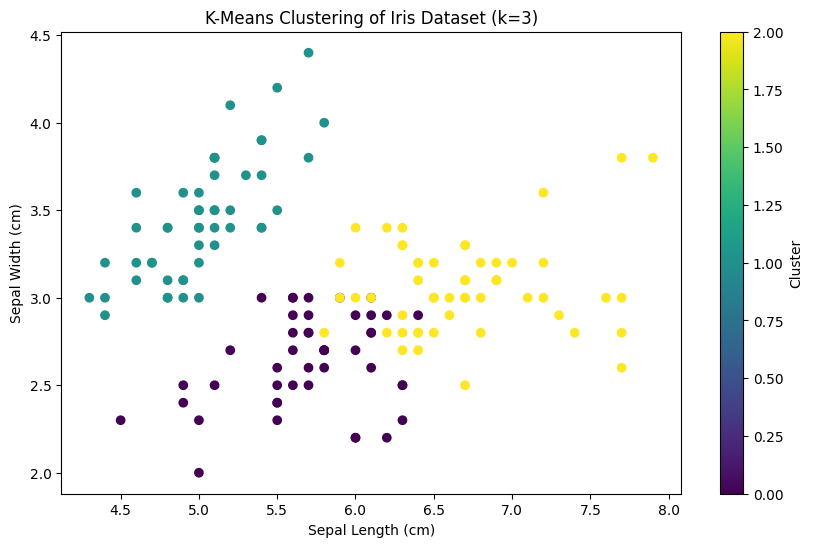

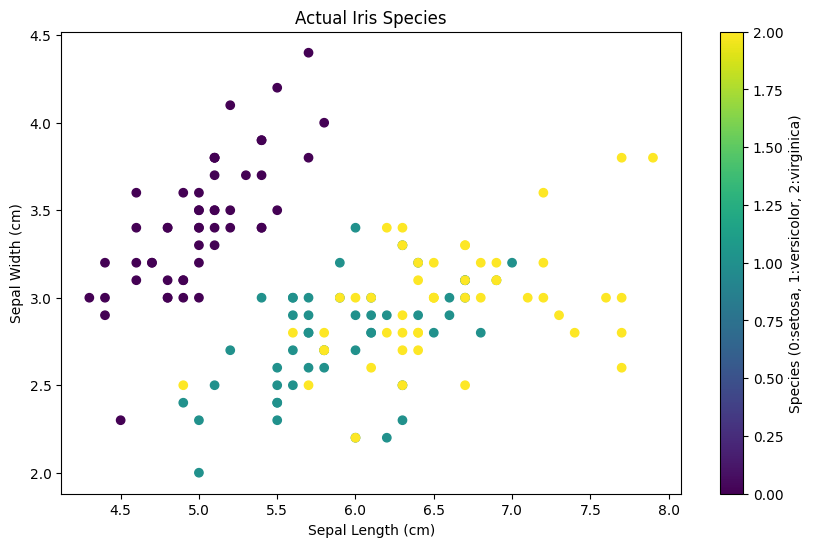


Cluster Centers (scaled features):
Cluster 0: [6.8887588  6.04493327 2.38782168 1.74828502]
Cluster 1: [6.05788156 7.91761264 0.83006151 0.32128819]
Cluster 2: [8.08674985 7.02050171 3.06927278 2.5427526 ]


In [5]:
#Q2 Build a Clustering Model with Spark with a dataset of your choice.
#I'll use the classic Iris dataset again, but this time for unsupervised learning where we'll cluster the flowers without using the species labels.

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("IrisClustering") \
    .getOrCreate()

# 1. Load the dataset
from sklearn.datasets import load_iris

# Load iris data into pandas dataframe
iris = load_iris()
pdf = pd.DataFrame(iris.data, columns=iris.feature_names)
pdf['species'] = pd.Series(iris.target).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Convert pandas dataframe to spark dataframe
df = spark.createDataFrame(pdf)
print("Original Data:")
df.show(5)

# 2. Prepare the data
# Combine features into a single vector column
feature_columns = iris.feature_names
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale the features (important for K-Means)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# 3. Create the clustering model
# Using K-Means with 3 clusters (since we know there are 3 species)
kmeans = KMeans(
    featuresCol="scaledFeatures",
    k=3,
    seed=42,
    maxIter=20
)

# Create pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# 4. Train the model
model = pipeline.fit(df)

# 5. Get cluster predictions
predictions = model.transform(df)
print("Cluster Assignments:")
predictions.select("features", "scaledFeatures", "prediction").show(5)

# 6. Evaluate the clustering
# Using Silhouette score (higher is better)
evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures",
    predictionCol="prediction",
    metricName="silhouette"
)

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette:.4f}")

# 7. Visualize the clusters (convert to pandas for visualization)
cluster_results = predictions.select("*").toPandas()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    cluster_results['sepal length (cm)'],
    cluster_results['sepal width (cm)'],
    c=cluster_results['prediction'],
    cmap='viridis'
)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('K-Means Clustering of Iris Dataset (k=3)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# 8. Compare with actual species (just for evaluation, not used in clustering)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    cluster_results['sepal length (cm)'],
    cluster_results['sepal width (cm)'],
    c=cluster_results['species'].astype('category').cat.codes,
    cmap='viridis'
)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Actual Iris Species')
plt.colorbar(scatter, label='Species (0:setosa, 1:versicolor, 2:virginica)')
plt.show()

# 9. Cluster centers
centers = model.stages[-1].clusterCenters()
print("\nCluster Centers (scaled features):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# Stop Spark session
spark.stop()

In [7]:
#Q3 Build a Recommendation Engine with Spark with a dataset of your choice
#I'll use the MovieLens dataset, a classic dataset for recommendation systems that contains user ratings for movies.


from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, explode
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("MovieRecommendation") \
    .getOrCreate()

# 1. Load the dataset
# Download the MovieLens small dataset (about 1MB) if not already available
import urllib.request
import zipfile
import os

data_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
data_file = "ml-latest-small.zip"
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)
    with zipfile.ZipFile(data_file, 'r') as zip_ref:
        zip_ref.extractall(".")

# Load ratings data
ratings = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
print("Ratings Data:")
ratings.show(5)

# Load movies data (for displaying movie titles)
movies = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)
print("\nMovies Data:")
movies.show(5)

# 2. Prepare the data
# Split into training and test sets
(train, test) = ratings.randomSplit([0.8, 0.2], seed=42)

# 3. Create and train the ALS model
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    seed=42
)

# Train the model
model = als.fit(train)

# 4. Evaluate the model
predictions = model.transform(test)

# Evaluate using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"\nRoot Mean Squared Error (RMSE) = {rmse:.4f}")

# 5. Generate recommendations
# Generate top 10 movie recommendations for each user
user_recs = model.recommendForAllUsers(10)
print("\nSample Recommendations for Users:")
user_recs.show(5, truncate=False)

# Generate top 10 user recommendations for each movie
movie_recs = model.recommendForAllItems(10)
print("\nSample Recommendations for Movies:")
movie_recs.show(5, truncate=False)

# 6. Show recommendations for a specific user (FIXED VERSION)
def get_recommendations_for_user(user_id, num_recs=10):
    # Get recommendations for the user
    user_recs_df = user_recs.filter(col("userId") == user_id)

    # Explode the recommendations array into rows
    recs_exploded = user_recs_df.select(
        "userId",
        explode("recommendations").alias("rec")
    ).select(
        "userId",
        col("rec.movieId").alias("movieId"),
        col("rec.rating").alias("predicted_rating")
    )

    # Join with movies to get titles - FIXED the ambiguous column reference
    recs_with_titles = recs_exploded.join(
        movies,
        recs_exploded["movieId"] == movies["movieId"]  # Explicit column reference
    ).select(
        recs_exploded["userId"],
        recs_exploded["movieId"],
        movies["title"],
        movies["genres"],
        "predicted_rating"
    ).orderBy(col("predicted_rating").desc())

    return recs_with_titles.limit(num_recs)

# Example: Get recommendations for user 42
print("\nTop 10 Recommendations for User 42:")
user_42_recs = get_recommendations_for_user(42)
user_42_recs.show(10, truncate=False)

# 7. Show similar movies to a specific movie (FIXED VERSION)
def get_similar_movies(movie_id, num_recs=10):
    # Get recommendations for the movie
    movie_recs_df = movie_recs.filter(col("movieId") == movie_id)

    # Explode the recommendations array into rows
    recs_exploded = movie_recs_df.select(
        "movieId",
        explode("recommendations").alias("rec")
    ).select(
        "movieId",
        col("rec.userId").alias("userId"),
        col("rec.rating").alias("predicted_rating")
    )

    # Join with movies to get titles - FIXED the ambiguous column reference
    recs_with_titles = recs_exploded.join(
        movies,
        recs_exploded["movieId"] == movies["movieId"]  # Explicit column reference
    ).select(
        recs_exploded["userId"],
        recs_exploded["movieId"],
        movies["title"],
        movies["genres"],
        "predicted_rating"
    ).orderBy(col("predicted_rating").desc())

    return recs_with_titles.limit(num_recs)

# Example: Get movies similar to movie 50 (Star Wars)
print("\nMovies Similar to Movie 50 (Star Wars):")
movie_50_similar = get_similar_movies(50)
movie_50_similar.show(10, truncate=False)

# Stop Spark session
spark.stop()

Ratings Data:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows


Movies Data:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows


Root Mean Squared Error (RMSE) = 1.0310

Sample Recommendations for Users:
+------+----------------------------------------------------------------